<a href="https://colab.research.google.com/github/laylacamilesb/Previsao-RUL-de-Motores-com-Machine-Learning/blob/main/PrognosticoRUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Preparação do Ambiente e Importações**

In [ ]:
# -------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Módulos do Scikit-learn para Regressão, Pré-processamento e Métricas
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler

# Módulo para conectar ao Google Drive
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Carregamento dos Dados (train_FD001.txt)**

In [ ]:
# -------------------------------------------------
# 2. CARREGAMENTO DOS DADOS - C-MAPSS FD001
# -------------------------------------------------

# Nomes das 26 colunas conforme C-MAPSS
colunas = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + \
          ['sensor' + str(i) for i in range(1, 22)]

# Caminho do arquivo no drive
caminho_do_arquivo = '/content/drive/MyDrive/Colab Notebooks/IA aeroespacial/train_FD001.txt'

# Carregar o arquivo TXT usando espaço como separador
df_treino = pd.read_csv(
    caminho_do_arquivo,
    sep='\s+',
    header=None,
    names=colunas
)

print("---")
print("DataFrame carregado e colunas nomeadas:")
print(df_treino.head())
print(f"Total de amostras: {len(df_treino)}")
print("---")

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1666421789.py:15: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


---
DataFrame carregado e colunas nomeadas:
   engine_id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0          1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1          1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2          1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3          1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4          1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   

   sen

# **3. Engenharia de Features: Cálculo da Variável Alvo (RUL)**

In [ ]:
# -------------------------------------------------------------------------
# 3. ENGENHARIA DE FEATURES: CÁLCULO DA RUL E CRIAÇÃO DE FEATURES TEMPORAIS
# -------------------------------------------------------------------------

import pandas as pd

# 3.1. Mapear o ciclo máximo para cada motor
max_cycles = df_treino.groupby('engine_id')['cycle'].max()
df_treino['max_cycle'] = df_treino['engine_id'].map(max_cycles)

# 3.2. Calcular a RUL
df_treino['RUL'] = df_treino['max_cycle'] - df_treino['cycle']

# Colunas dos sensores que variam (usar para criar as médias móveis)
sensor_cols_para_calculo = [
    'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 'sensor11',
    'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21'
]

# 3.3. Engenharia de Features Temporal (Médias Móveis e Volatilidade)

# A. Média Móvel (Rolling Mean): Suaviza o ruído e captura a tendência
for col in sensor_cols_para_calculo:
    df_treino[f'{col}_mean_10'] = df_treino.groupby('engine_id')[col].transform(   #Window=10 é o tamanho da janela dos ciclos anteriores (10 ciclos)
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

# B. Volatilidade (Rolling Standard Deviation): Captura o aumento de variância (instabilidade)
for col in sensor_cols_para_calculo:
    df_treino[f'{col}_std_10'] = df_treino.groupby('engine_id')[col].transform(
        lambda x: x.rolling(window=10, min_periods=1).std().fillna(0)
    )

print(f"Cálculo da RUL concluído. {len(sensor_cols_para_calculo) * 2} novas features temporais foram adicionadas.")
print(f"Total de colunas no dataframe de treino após Features Engineering: {df_treino.shape[1]}")
print("---")

Cálculo da RUL concluído. 28 novas features temporais foram adicionadas.
Total de colunas no dataframe de treino após Features Engineering: 56
---


# **4. Pré-processamento e Separação de Dados**

In [ ]:
# -------------------------------------------------
# 4. PRÉ-PROCESSAMENTO: LIMPEZA E NORMALIZAÇÃO
# -------------------------------------------------

# 4.1. Limpeza/Seleção de Features (Colunas que não variam no FD001)
colunas_irrelevantes = ['engine_id', 'max_cycle', 'setting3',
                        'sensor1', 'sensor5', 'sensor6', 'sensor10',
                        'sensor16', 'sensor18', 'sensor19']

# 4.2. Definindo Variáveis X (Features) e Y (Alvo)
y = df_treino['RUL']
X = df_treino.drop(columns=colunas_irrelevantes + ['RUL', 'cycle'])

# 4.3. Normalização: RobustScaler (melhor para dados com outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Features (X) selecionadas: {X_scaled.columns.tolist()}")
print(f"Número de features após a limpeza: {X_scaled.shape[1]}")
print("---")

# 4.4. Divisão temporal dos dados (Validação Temporal)
def temporal_train_test_split(X, y, test_size=0.2):  #Preserva a ordem temporal e evita data leakage
    split_idx = int(len(X) * (1 - test_size))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

X_train, X_test, y_train, y_test = temporal_train_test_split(X_scaled, y, test_size=0.20)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("---")

Features (X) selecionadas: ['setting1', 'setting2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21', 'sensor2_mean_10', 'sensor3_mean_10', 'sensor4_mean_10', 'sensor7_mean_10', 'sensor8_mean_10', 'sensor9_mean_10', 'sensor11_mean_10', 'sensor12_mean_10', 'sensor13_mean_10', 'sensor14_mean_10', 'sensor15_mean_10', 'sensor17_mean_10', 'sensor20_mean_10', 'sensor21_mean_10', 'sensor2_std_10', 'sensor3_std_10', 'sensor4_std_10', 'sensor7_std_10', 'sensor8_std_10', 'sensor9_std_10', 'sensor11_std_10', 'sensor12_std_10', 'sensor13_std_10', 'sensor14_std_10', 'sensor15_std_10', 'sensor17_std_10', 'sensor20_std_10', 'sensor21_std_10']
Número de features após a limpeza: 44
---
X_train shape: (16504, 44)
y_train shape: (16504,)
---


# **5. Modelo Baseline: Treinamento e Avaliação da Regressão Linear**

In [ ]:
# ----------------------------------------------------------------
# 5. MODELO BASELINE: TREINAMENTO E AVALIAÇÃO DA REGRESSÃO LINEAR
# ----------------------------------------------------------------

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Definir a grade de hiperparâmetros
parameters = {'fit_intercept': [True, False]} # Testar com e sem intercepto

print("Executando GridCV para Regressão Linear (Baseline)...")

# Criar o modelo e buscar em grade (GridSearch) com 5-fold Cross-Validation
LR_model = GridSearchCV(LinearRegression(), parameters, cv=5, scoring='r2', n_jobs=-1)

# Treinar o modelo:
LR_model.fit(X_train, y_train)

best_params = LR_model.best_params_
print(f"Melhores hiperparâmetros encontrados: {best_params}")
print("Modelo de Regressão Linear (Baseline) treinado.")


# --- AVALIAÇÃO E SALVAMENTO DE MÉTRICAS ---

# I. Previsão nos dados de teste
y_pred_lr = LR_model.predict(X_test)

# II. Cálculo das métricas
LR_mse = mean_squared_error(y_test, y_pred_lr)
LR_r2 = r2_score(y_test, y_pred_lr)
LR_rmse = np.sqrt(LR_mse)
LR_mae = mean_absolute_error(y_test, y_pred_lr)

# III. Salvar as métricas nas variáveis que serão usadas na Seção 7
LR_RMSE = LR_rmse
LR_R2 = LR_r2
LR_MAE = LR_mae

print("\n--- MÉTRICAS DE VALIDAÇÃO INTERNA (Regressão Linear) ---")
print(f"R² Score (Quanto mais perto de 1, melhor): {LR_R2:.4f}")
print(f"Root Mean Squared Error (RMSE): {LR_RMSE:.2f}")
print(f"Mean Absolute Error (MAE): {LR_MAE:.2f}")
print("---------------------------------------------------------")

Executando GridCV para Regressão Linear (Baseline)...
Melhores hiperparâmetros encontrados: {'fit_intercept': True}
Modelo de Regressão Linear (Baseline) treinado.

--- MÉTRICAS DE VALIDAÇÃO INTERNA (Regressão Linear) ---
R² Score (Quanto mais perto de 1, melhor): 0.5303
Root Mean Squared Error (RMSE): 53.91
Mean Absolute Error (MAE): 40.29
---------------------------------------------------------


# **6. Treinamento do Modelo Random Forest Regressor**

In [ ]:
# ==============================================================================
# 6. TREINAMENTO DO MODELO RANDOM FOREST REGRESSOR
# ==============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir a grade de hiperparâmetros
parameters = {
     'n_estimators': [100, 200],              # Número de árvores
     'max_depth': [10, 20],                   # Profundidade máxima
     'max_features': [0.6, 0.8, 1.0],         # Porcentagem de features a considerar
     'min_samples_leaf': [5, 10],             # Mínimo de amostras na folha
     'random_state': [42]
}

print("Executando GridCV para Random Forest Regressor...")

# Criar modelo e buscar em grade (GridSearch)
RF_model = GridSearchCV(RandomForestRegressor(), parameters, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)  #Usando RMSE (negativo) como métrica de scoring para otimização

# Treinar o modelo
RF_model.fit(X_train, y_train)

best_params = RF_model.best_params_
print(f"Melhores hiperparâmetros encontrados: {best_params}")

print("Modelo Random Forest treinado.")

Executando GridCV para Random Forest Regressor...
Melhores hiperparâmetros encontrados: {'max_depth': 10, 'max_features': 0.6, 'min_samples_leaf': 10, 'n_estimators': 200, 'random_state': 42}
Modelo Random Forest treinado.


# **7. Modelo Candidato: Avaliação do Random Forest**


--- MÉTRICAS DE VALIDAÇÃO INTERNA (Random Forest) ---
R² Score (Quanto mais perto de 1, melhor): 0.5569
Root Mean Squared Error (RMSE): 52.36
Mean Absolute Error (MAE): 37.16
---------------------------------------------------------

=== ANÁLISE DE IMPORTÂNCIA DE FEATURES ===
Top 10 Features Mais Importantes para RUL:
             feature  importance
18   sensor4_mean_10    0.388547
29  sensor21_mean_10    0.154620
22  sensor11_mean_10    0.117377
21   sensor9_mean_10    0.080101
26  sensor15_mean_10    0.040142
25  sensor14_mean_10    0.031172
17   sensor3_mean_10    0.023389
27  sensor17_mean_10    0.022565
23  sensor12_mean_10    0.014117
19   sensor7_mean_10    0.013154


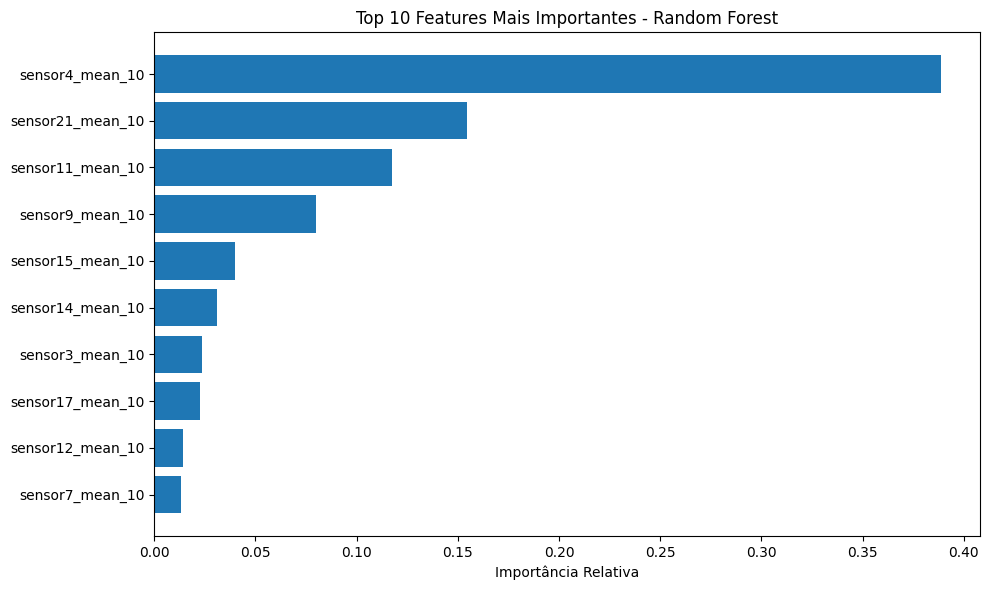

In [ ]:
# ===================================
# 6. AVALIAÇÃO DA VALIDAÇÃO INTERNA
# ===================================

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 7.1. Previsão nos dados de teste interno (X_test)
y_pred = RF_model.predict(X_test)   #'RF_model' é o modelo treinado anteriormente

# 7.2. Avaliação do modelo usando as métricas de Regressão
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Salvando as novas métricas para comparação
RF_R2 = r2
RF_RMSE = rmse
RF_MAE = mae

# Exibir as métricas
print("\n--- MÉTRICAS DE VALIDAÇÃO INTERNA (Random Forest) ---")
print(f"R² Score (Quanto mais perto de 1, melhor): {RF_R2:.4f}")
print(f"Root Mean Squared Error (RMSE): {RF_RMSE:.2f}")
print(f"Mean Absolute Error (MAE): {RF_MAE:.2f}")
print("---------------------------------------------------------")


# 7.3. Análise de importância das Features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': RF_model.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== ANÁLISE DE IMPORTÂNCIA DE FEATURES ===")
print("Top 10 Features Mais Importantes para RUL:")
print(feature_importance.head(10))

# Plotagem
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(10)[::-1],
         feature_importance['importance'].head(10)[::-1])
plt.xlabel('Importância Relativa')
plt.title('Top 10 Features Mais Importantes - Random Forest')
plt.tight_layout()
plt.show()

# **8. Visualização e Análise de Desempenho**

O melhor modelo encontrado é o: Random Forest

--- Tabela de Comparação de Desempenho ---
                     Modelo  R² Score    RMSE     MAE
Regressão Linear (Baseline)    0.5303 53.9127 40.2928
  Random Forest (Otimizado)    0.5569 52.3644 37.1624
------------------------------------------


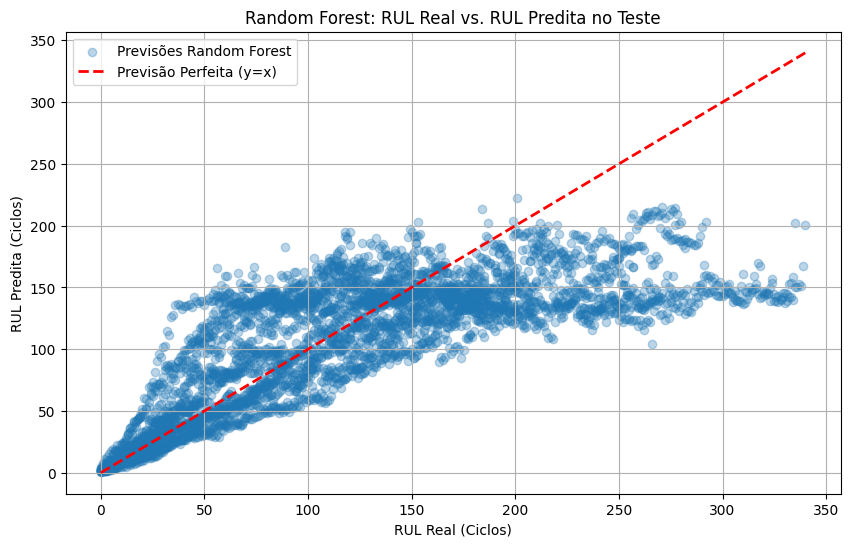

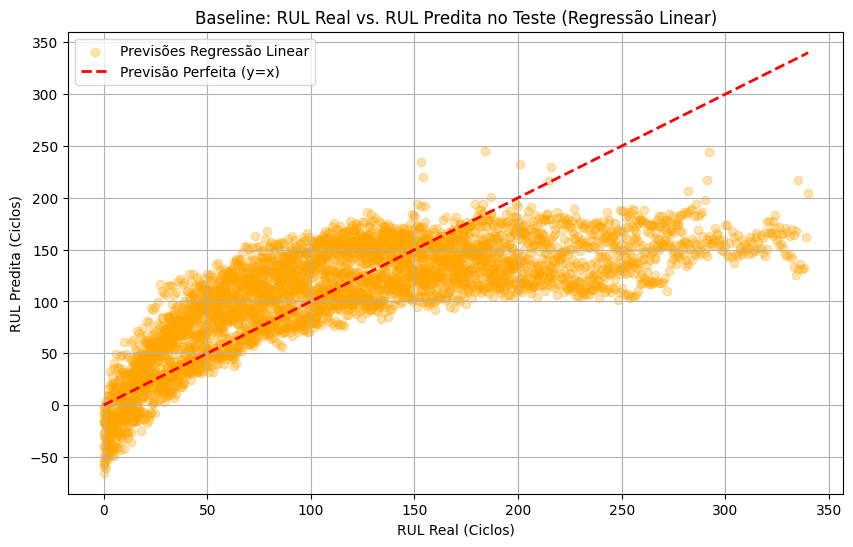

In [ ]:
#=================================================
# 8. ANÁLISE DE DESEMPENHO E COMPARAÇÃO DOS 2 MODELOS
#=================================================

import pandas as pd

# DataFrame de comparação
data = {
    'Modelo': ['Regressão Linear (Baseline)', 'Random Forest (Otimizado)'],
    'R² Score': [LR_R2, RF_R2],
    'RMSE': [LR_RMSE, RF_RMSE],
    'MAE': [LR_MAE, RF_MAE]
}

df_comparacao = pd.DataFrame(data)

# Definir o modelo vencedor
melhor_modelo = 'Random Forest' if RF_RMSE < LR_RMSE else 'Regressão Linear'

print(f"O melhor modelo encontrado é o: {melhor_modelo}")
print("\n--- Tabela de Comparação de Desempenho ---")
print(df_comparacao.to_string(index=False, float_format="%.4f"))
print("------------------------------------------")


#============================================================
# 8.1. Plot Real vs. Predito (Random Forest)
#============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotar os valores Reais (y_test) vs. os Preditos (y_pred)
plt.scatter(y_test, y_pred, alpha=0.3, label='Previsões Random Forest')

# Plotar a linha de previsão perfeita (y = x).
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--r', lw=2, label='Previsão Perfeita (y=x)')

plt.xlabel('RUL Real (Ciclos)')
plt.ylabel('RUL Predita (Ciclos)')
plt.title('Random Forest: RUL Real vs. RUL Predita no Teste')
plt.legend()
plt.grid(True)
plt.show()


#============================================================
# 8.2. Plot Real vs. Predito (Regressão Linear)
#============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# y_pred_lr é a previsão do modelo de Regressão Linear, salva na Seção 4
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='orange', label='Previsões Regressão Linear')

# Linha de previsão perfeita (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--r', lw=2, label='Previsão Perfeita (y=x)')

plt.xlabel('RUL Real (Ciclos)')
plt.ylabel('RUL Predita (Ciclos)')
plt.title('Baseline: RUL Real vs. RUL Predita no Teste (Regressão Linear)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
drive.flush_and_unmount()